<a href="https://colab.research.google.com/github/danphan/Drug-Review-Sentiment-Analysis/blob/main/train_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#obtain drugs dataset

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip drugsCom_raw.zip

--2022-12-26 02:28:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  12.0MB/s    in 3.4s    

2022-12-26 02:28:40 (12.0 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [ ]:
#install datasets and transformers
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 35.6 MB/s 
     |████████████████████████████████| 182 kB 80.0 MB/s 
     |████████████████████████████████| 7.6 MB 64.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 39.9 MB/s 
     |████████████████████████████████| 212 kB 73.7 MB/s 
     |████████████████████████████████| 132 kB 74.7 MB/s 
     |████████████████████████████████| 127 kB 73.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.model_selection import train_test_split


In [ ]:
data = pd.read_csv('drugsComTrain_raw.tsv',sep='\t')

data['review'] = data['review'].apply(lambda x: x[1:-1])
data['review'] = data['review'].apply(lambda x: x.replace('&#039;', "'"))
data['review'] = data['review'].apply(lambda x: x.replace('&amp;', "and"))

data['sentiment'] = data['rating'].apply(lambda x: 1 if x > 5 else 0)

condition = 'Birth Control'
data_bc = data[data['condition'] == condition].copy()

df_train, df_val= train_test_split(data_bc[['review','sentiment']], test_size=0.2, random_state=42)

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)


def tokenize_function(example):
    return tokenizer(example['review'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf") #dynamic padder

def create_dataset(df):

    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize_function, batched=True)

    return ds.to_tf_dataset(
        columns=["input_ids", "token_type_ids", "attention_mask"],
        label_cols=["sentiment"],
        batch_size=8,
        collate_fn=data_collator,
        shuffle=True
    )

ds_train = create_dataset(df_train)
ds_val = create_dataset(df_val)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/24 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
batch_size = 8
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(ds_train) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

opt = Adam(learning_rate=lr_scheduler)

model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    ds_train,
    epochs = num_epochs, 
    verbose= 1,
    validation_data = ds_val
)

Epoch 1/3
2879/2879 [==============================] - 1082s 370ms/step - loss: 0.3474 - accuracy: 0.8432 - val_loss: 0.2425 - val_accuracy: 0.9041
Epoch 2/3
2879/2879 [==============================] - 1061s 369ms/step - loss: 0.1780 - accuracy: 0.9351 - val_loss: 0.1821 - val_accuracy: 0.9319
Epoch 3/3
2879/2879 [==============================] - 1063s 369ms/step - loss: 0.0630 - accuracy: 0.9816 - val_loss: 0.1912 - val_accuracy: 0.9493


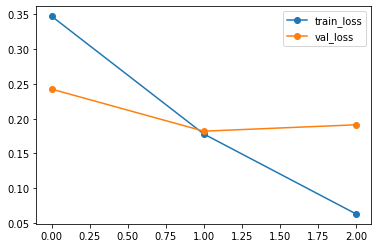

In [ ]:
plt.plot(history.history['loss'],'o-',label='train_loss')
plt.plot(history.history['val_loss'],'o-',label = 'val_loss')
plt.legend();